#### **Load and Filter Data**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load dataset metadata and filter to 'normal' and 'pneumonia' classes
csv_path = "/content/drive/MyDrive/NIH_ChestXray/Data_Entry_2017_v2020.csv"
image_dir = "/content/drive/MyDrive/NIH_ChestXray/images_extracted/images"

df = pd.read_csv(csv_path)
df['class'] = df['Finding Labels'].apply(
    lambda x: 'normal' if x == 'No Finding' else
              'pneumonia' if 'Pneumonia' in x else
              'other'
)
df = df[df['class'].isin(['normal', 'pneumonia'])]
df['filepath'] = df['Image Index'].apply(lambda x: os.path.join(image_dir, x))
df = df[df['filepath'].apply(os.path.exists)]

print(f"Dataset loaded: {len(df)} images")
print(f"Normal: {len(df[df['class'] == 'normal'])}")
print(f"Pneumonia: {len(df[df['class'] == 'pneumonia'])}")

# Print original class ratio
orig_normal = len(df[df['class'] == 'normal'])
orig_pneumonia = len(df[df['class'] == 'pneumonia'])
print(f"Original normal:pneumonia ratio = {orig_normal}/{orig_pneumonia} = {orig_normal/orig_pneumonia:.2f}:1")

Dataset loaded: 61788 images
Normal: 60357
Pneumonia: 1431
Original normal:pneumonia ratio = 60357/1431 = 42.18:1


#### **Distribution of NIH Dataset**

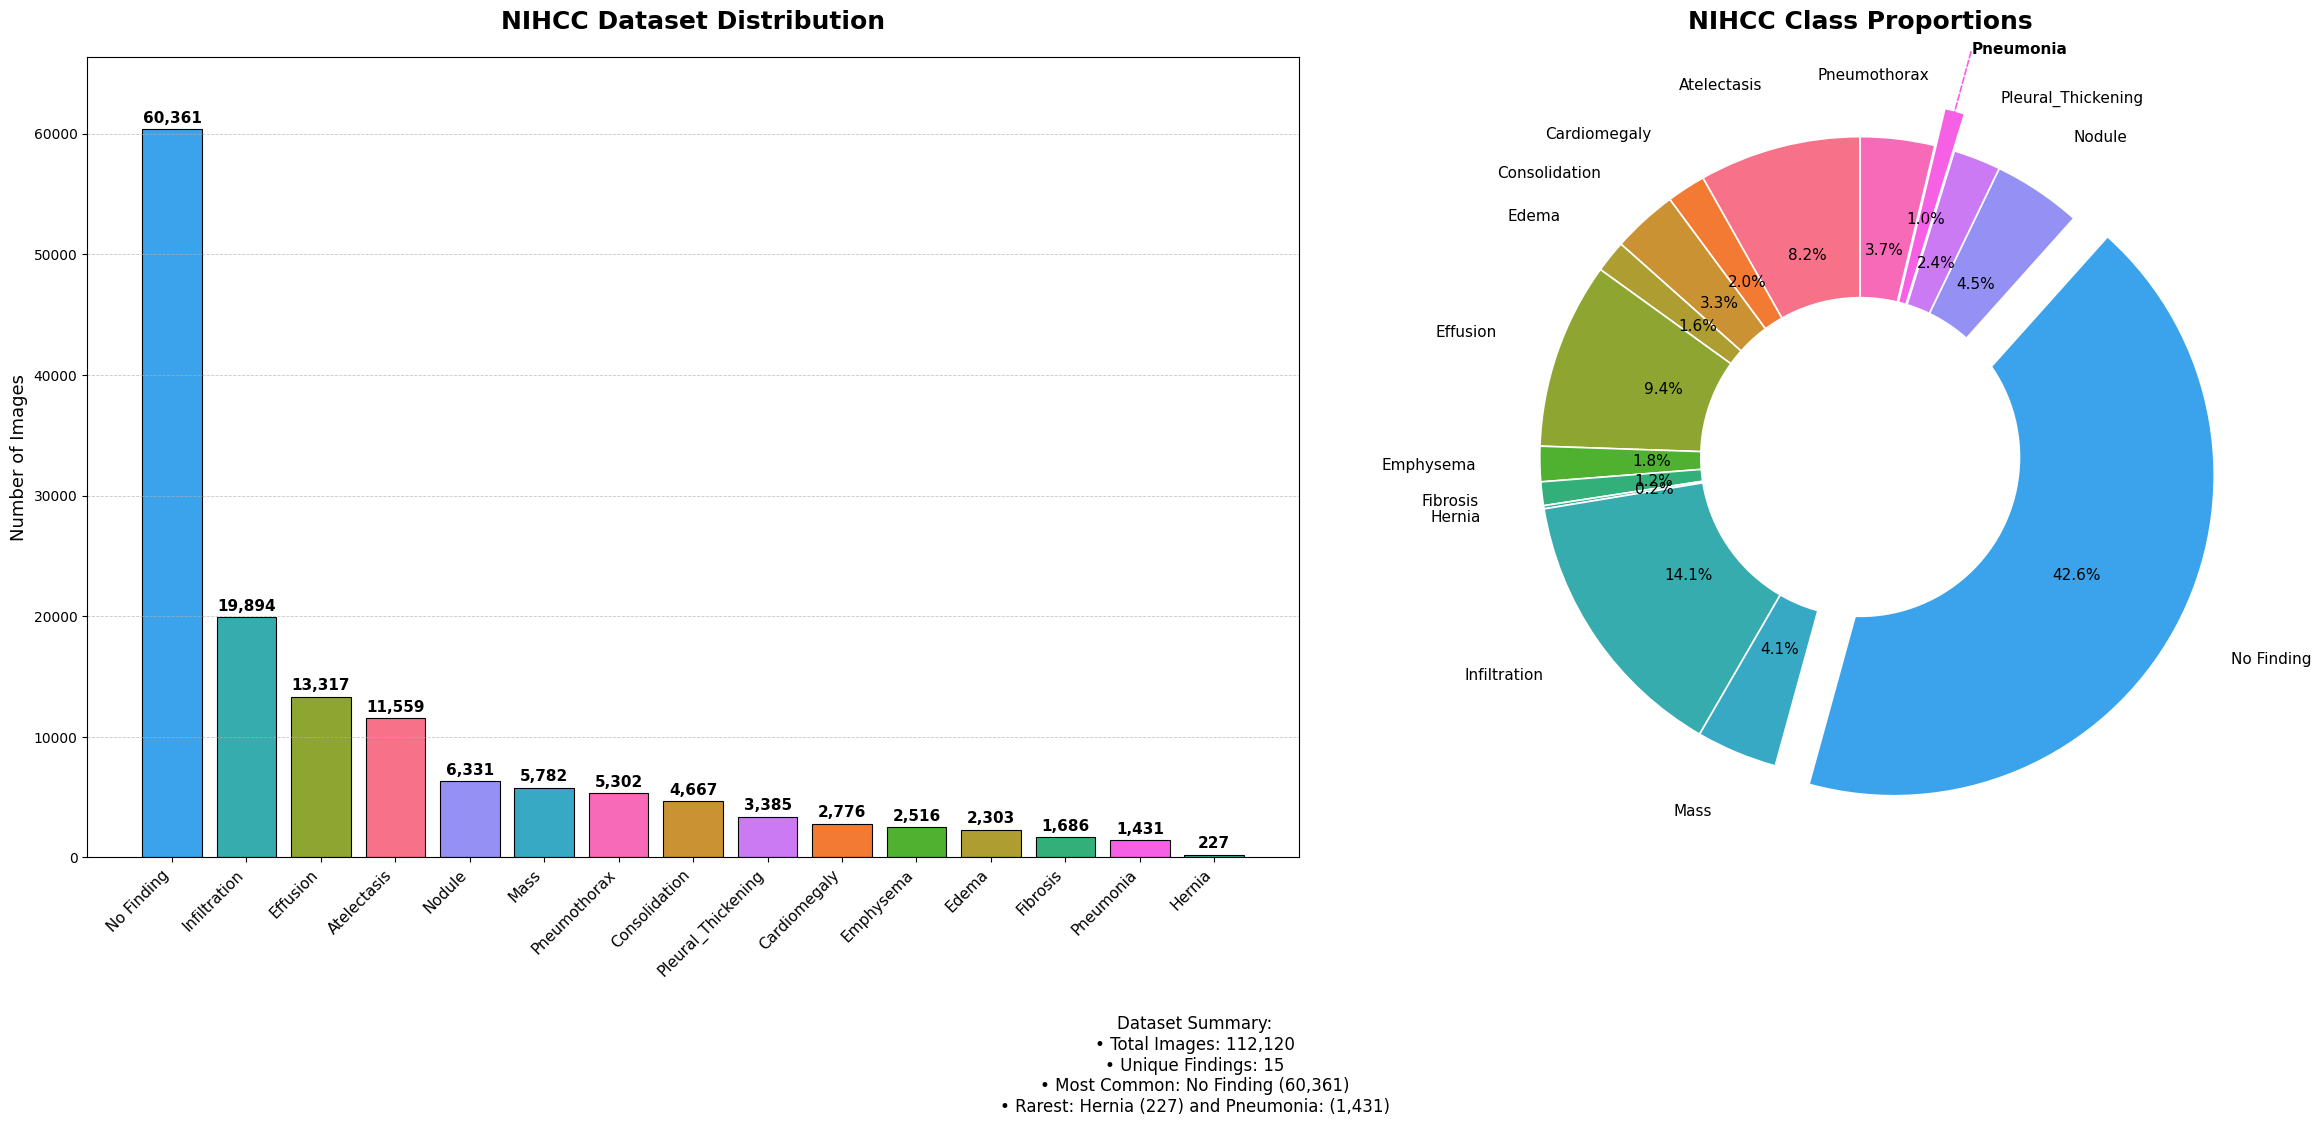

In [ ]:
# File path
csv_path = "/content/drive/MyDrive/NIH_ChestXray/Data_Entry_2017_v2020.csv"

# Read the CSV
df = pd.read_csv(csv_path)

# Extract all unique labels (alphabetical) from “Finding Labels”
all_labels = sorted({
    lab.strip()
    for row in df["Finding Labels"]
    for lab in row.split("|")
})

#  Count how many rows contain each label
counts = [int(df["Finding Labels"].str.contains(lbl).sum()) for lbl in all_labels]

# Create a color map so each label has a fixed, truly unique color
#    Using seaborn “husl” palette for 15 distinct, easily distinguishable colors
palette = sns.color_palette("husl", len(all_labels))
color_map = dict(zip(all_labels, palette))

# Prepare sorted lists for the bar chart only (descending by count)
label_count_pairs = sorted(
    zip(all_labels, counts),
    key=lambda x: x[1],
    reverse=True
)
sorted_labels, sorted_counts = zip(*label_count_pairs)

# Create side-by-side subplots
fig, (ax_bar, ax_pie) = plt.subplots(
    1,
    2,
    figsize=(24, 10),
    gridspec_kw={"width_ratios": [1.3, 1]},
)

# BAR CHART on ax_bar (descending order, colors from color_map)
plt.style.use("ggplot")

bar_colors = [color_map[label] for label in sorted_labels]
x_pos = range(len(sorted_labels))
bars = ax_bar.bar(x_pos, sorted_counts, color=bar_colors, edgecolor="black", linewidth=0.8)

# Annotate each bar with its raw count (bold, slightly above)
for bar, cnt in zip(bars, sorted_counts):
    h = bar.get_height()
    ax_bar.text(
        bar.get_x() + bar.get_width() / 2,
        h + max(sorted_counts) * 0.005,
        f"{cnt:,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

ax_bar.set_xticks(x_pos)
ax_bar.set_xticklabels(sorted_labels, rotation=45, ha="right", fontsize=11)
ax_bar.set_ylabel("Number of Images", fontsize=13)
ax_bar.set_title("NIHCC Dataset Distribution", fontsize=18, fontweight="bold", pad=20)
ax_bar.set_ylim(0, max(sorted_counts) * 1.10)
ax_bar.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)
ax_bar.xaxis.grid(False)

# PIE CHART on ax_pie (alphabetical order, using same color_map)
explode = [0.0] * len(all_labels)
explode[all_labels.index("Pneumonia")] = 0.12
explode[all_labels.index("No Finding")] = 0.12

pie_colors = [color_map[label] for label in all_labels]
wedges, texts, autotexts = ax_pie.pie(
    counts,
    labels=all_labels,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.65,
    labeldistance=1.2,
    explode=explode,
    colors=pie_colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1.2},
    textprops={"fontsize": 11},
)

ax_pie.set_title("NIHCC Class Proportions", fontsize=18, fontweight="bold", pad=20)
centre_circle = plt.Circle((0, 0), 0.50, fc="white")
ax_pie.add_artist(centre_circle)

# Bold only “Pneumonia” label at its default position
idx_pneum = all_labels.index("Pneumonia")
texts[idx_pneum].set_fontweight("bold")

# Draw a straight dashed line from the Pneumonia wedge to its bold label
mid_angle_pn = (wedges[idx_pneum].theta1 + wedges[idx_pneum].theta2) / 2
angle_rad_pn = np.deg2rad(mid_angle_pn)
x_w_pn, y_w_pn = np.cos(angle_rad_pn) * 0.7, np.sin(angle_rad_pn) * 0.7

x_label_pn, y_label_pn = texts[idx_pneum].get_position()
ax_pie.annotate(
    "",
    xy=(x_w_pn, y_w_pn),
    xytext=(x_label_pn, y_label_pn),
    arrowprops={
        "arrowstyle": "-",
        "linestyle": "--",
        "color": color_map["Pneumonia"],
        "linewidth": 1.2,
        "connectionstyle": "arc3,rad=0"
    },
)

# Shift “Pneumothorax” label left (normal weight) so it sits over its wedge
idx_ptx = all_labels.index("Pneumothorax")
mid_angle_ptx = (wedges[idx_ptx].theta1 + wedges[idx_ptx].theta2) / 2
angle_rad_ptx = np.deg2rad(mid_angle_ptx)
r_ptx_label = 1.2
x_w_ptx, y_w_ptx = np.cos(angle_rad_ptx) * r_ptx_label, np.sin(angle_rad_ptx) * r_ptx_label

# Remove default Pneumothorax text, then add a new one in black
texts[idx_ptx].set_text("")
ax_pie.text(
    x_w_ptx - 0.1,
    y_w_ptx,
    "Pneumothorax",
    ha="center",
    va="center",
    fontsize=11,
    fontweight="normal",
    color="black",
)

# Add summary statistics beneath the combined figure
# Compute summary:
total_images = len(df)
unique_findings = len(all_labels)
label_counts = pd.Series(counts, index=all_labels).sort_values(ascending=False)

most_common = label_counts.index[0]
most_common_count = label_counts.values[0]
rarest = label_counts.index[-1]
rarest_count = label_counts.values[-1]
rarest1 = label_counts.index[-2]
rarest_count1 = label_counts.values[-2]

summary_text = (
    "Dataset Summary:\n"
    f"• Total Images: {total_images:,}\n"
    f"• Unique Findings: {unique_findings}\n"
    f"• Most Common: {most_common} ({most_common_count:,})\n"
    f"• Rarest: {rarest} ({rarest_count:,}) and {rarest1}: ({rarest_count1:,})"
)

# Place summary text centered below both subplots
fig.text(
    0.5, -0.02, summary_text,
    ha="center", va="top", fontsize=12
)

plt.tight_layout()
plt.show()

#### **Visual For Normal Vrs Pneumonia**

In [ ]:
import pandas as pd
import numpy as np
import os
# Paths
csv_path = "/content/drive/MyDrive/NIH_ChestXray/pneumonia_vs_normal_unbalanced.csv"
image_dir = "/content/drive/MyDrive/NIH_ChestXray/images_extracted/images"


# Load and prepare dataset
print("Loading dataset...")
df = pd.read_csv(csv_path)
print("Original dataset size:", len(df))

# Create proper binary labels
df['class'] = df['Finding Labels'].apply(lambda x: 'pneumonia' if 'pneumonia' in x.lower() else 'normal')

# Map filenames to full paths
df['filepath'] = df['Image Index'].apply(lambda x: os.path.join(image_dir, x))

# Verify files exist
df = df[df['filepath'].apply(os.path.exists)]
print("Dataset size after verification:", len(df))

# Compute class counts
class_counts = df['class'].value_counts()
print("\nClass distribution:")
print(class_counts)

Loading dataset...
Original dataset size: 61792
Dataset size after verification: 61792

Class distribution:
class
normal       60361
pneumonia     1431
Name: count, dtype: int64


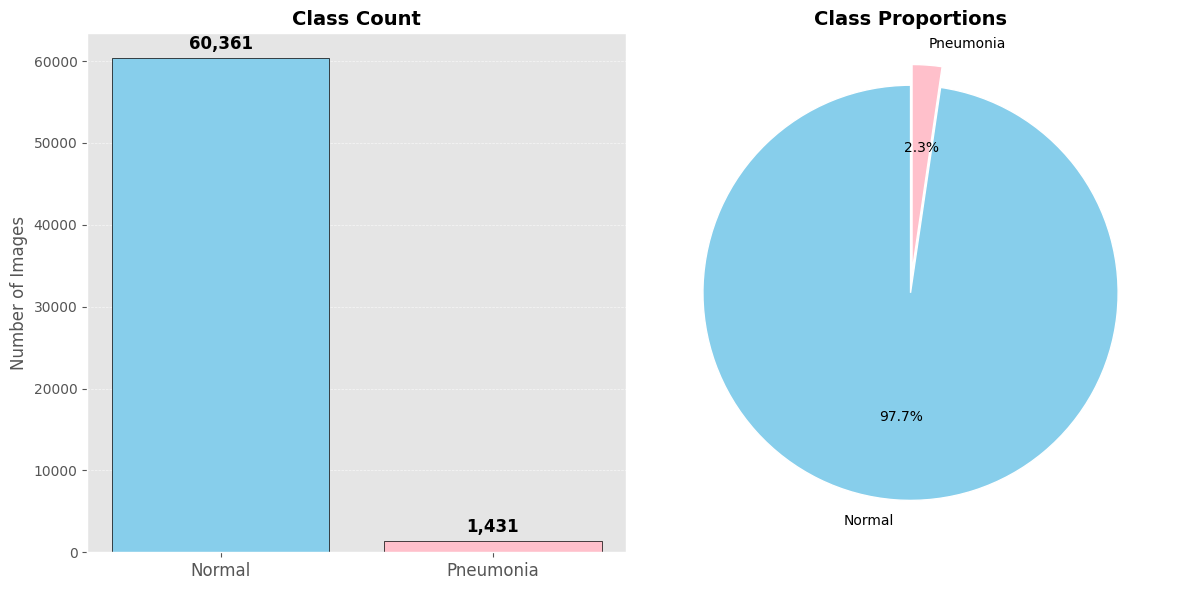

In [ ]:
import matplotlib.pyplot as plt

# Visualization: side-by-side bar & pie

# Define labels and counts in consistent order
labels = ['normal', 'pneumonia']
counts = [class_counts.get('normal', 0), class_counts.get('pneumonia', 0)]

# Color mapping
color_map = {'normal': 'skyblue', 'pneumonia': 'pink'}
bar_colors = [color_map[label] for label in labels]
pie_colors = [color_map[label] for label in labels]

# Create subplots
fig, (ax_bar, ax_pie) = plt.subplots(1, 2, figsize=(12, 6))

# 1) BAR CHART with count annotations
x_pos = range(len(labels))
bars = ax_bar.bar(x_pos, counts, color=bar_colors, edgecolor="black")

for bar, cnt in zip(bars, counts):
    height = bar.get_height()
    ax_bar.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f"{cnt:,}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

ax_bar.set_xticks(x_pos)
ax_bar.set_xticklabels([lbl.capitalize() for lbl in labels], fontsize=12)
ax_bar.set_ylabel("Number of Images", fontsize=12)
ax_bar.set_title("Class Count", fontsize=14, fontweight="bold")
ax_bar.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax_bar.xaxis.grid(False)

# 2) PIE CHART with percentage annotations and explode pneumonia
explode = [0.0, 0.1]  # explode only the pneumonia slice
ax_pie.pie(
    counts,
    labels=[lbl.capitalize() for lbl in labels],
    autopct="%1.1f%%",
    startangle=90,
    colors=pie_colors,
    explode=explode,
    wedgeprops={"edgecolor": "white", "linewidth": 1}
)
ax_pie.set_title("Class Proportions", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

#### **Sample Images**

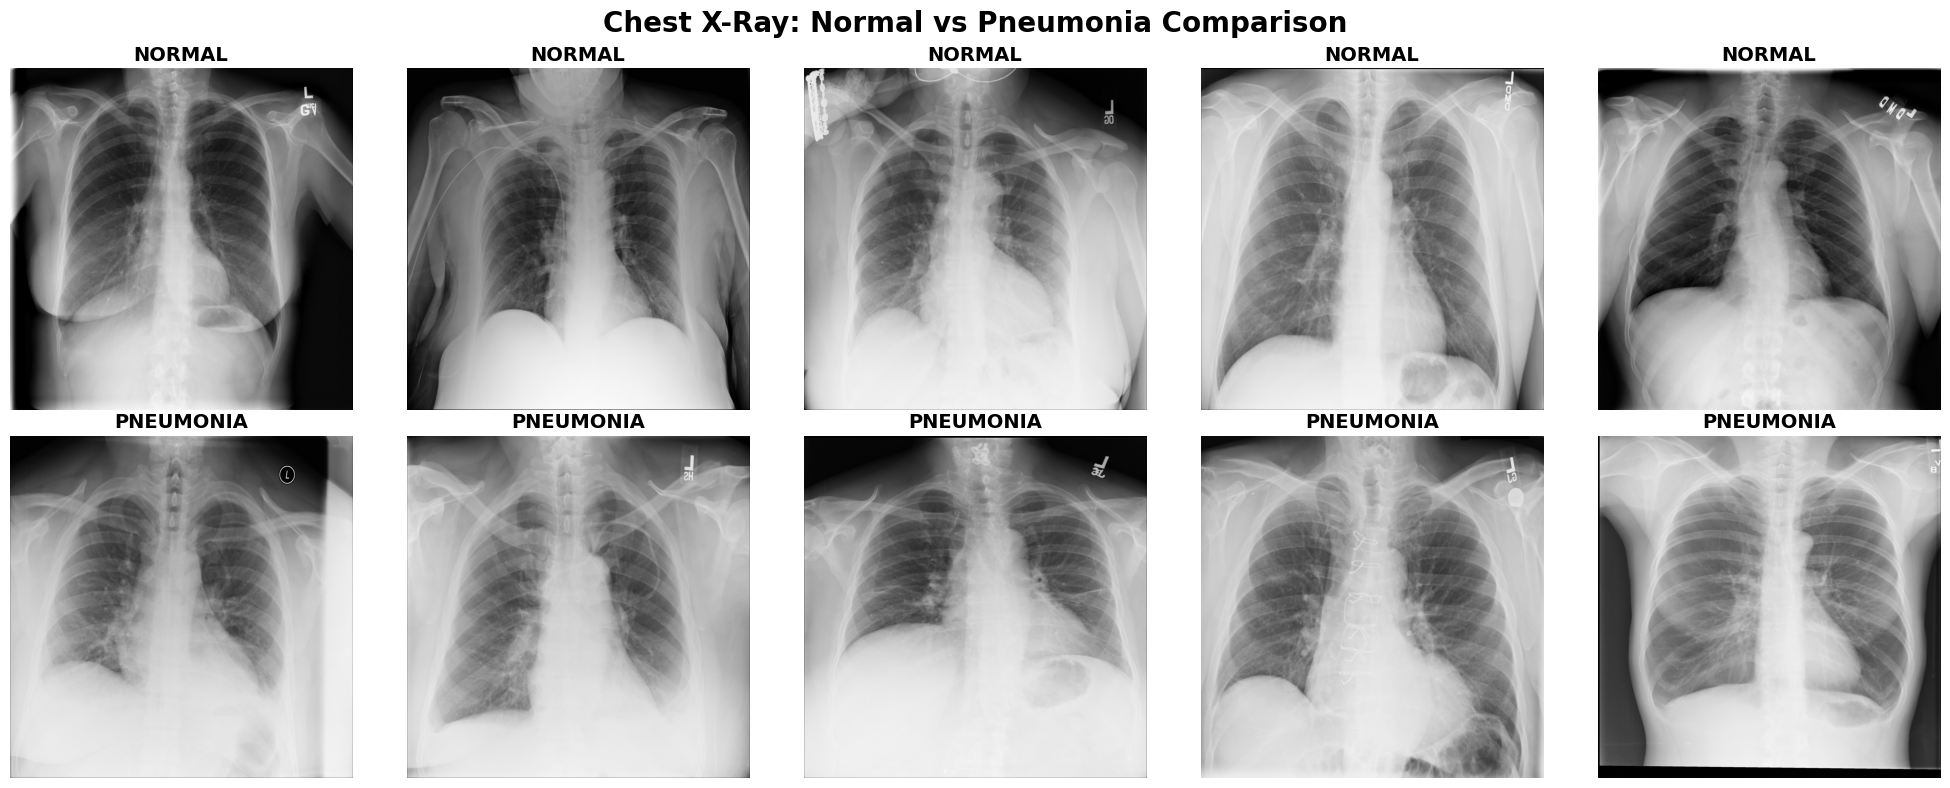

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set style and font settings
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

# Create figure
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Chest X-Ray: Normal vs Pneumonia Comparison', fontsize=20, fontweight='bold', y=0.98)

# Sample 5 normal and 5 pneumonia cases
normal_samples = df[df['class'] == 'normal'].sample(5, random_state=42)
pneumonia_samples = df[df['class'] == 'pneumonia'].sample(5, random_state=42)

# Plot normal images
for idx, (_, row) in enumerate(normal_samples.iterrows()):
    img = mpimg.imread(row['filepath'])
    axes[0, idx].imshow(img, cmap='gray')
    axes[0, idx].set_title('NORMAL', fontsize=14, fontweight='bold', color='black')
    axes[0, idx].axis('off')

# Plot pneumonia images
for idx, (_, row) in enumerate(pneumonia_samples.iterrows()):
    img = mpimg.imread(row['filepath'])
    axes[1, idx].imshow(img, cmap='gray')
    axes[1, idx].set_title('PNEUMONIA', fontsize=14, fontweight='bold', color='black')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

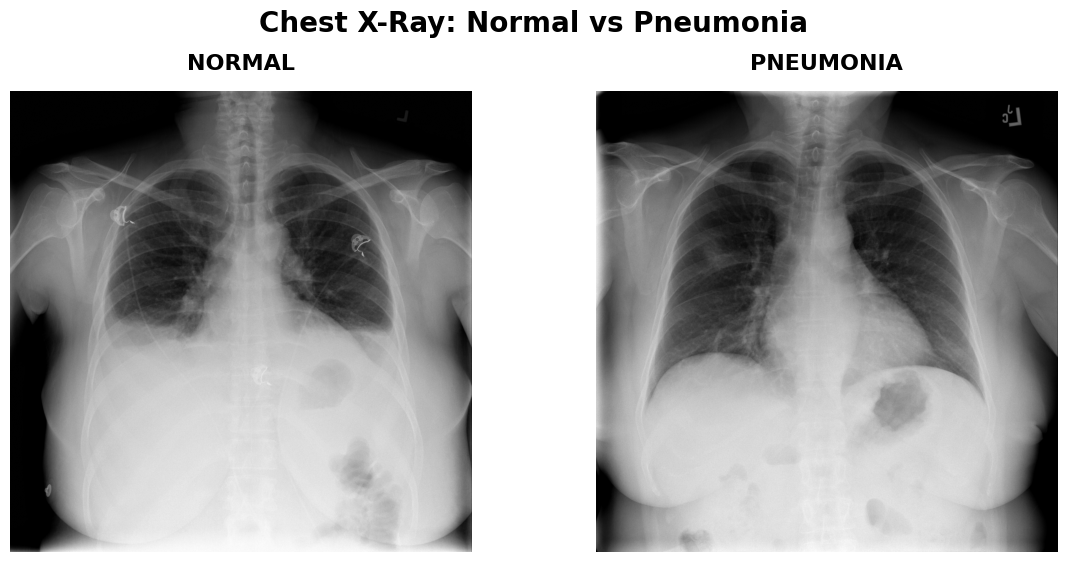

In [ ]:
# Create side-by-side comparison with adjusted spacing
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Chest X-Ray: Normal vs Pneumonia', fontsize=20, fontweight='bold', y=0.95)

# Sample one normal and one pneumonia case
normal_sample = df[df['class'] == 'normal'].sample(1).iloc[0]
pneumonia_sample = df[df['class'] == 'pneumonia'].sample(1).iloc[0]

# Display images with adjusted title spacing
axes[0].imshow(plt.imread(normal_sample['filepath']), cmap='gray')
axes[0].set_title('NORMAL', fontsize=16, fontweight='bold', color='black', pad=15)
axes[0].axis('off')

axes[1].imshow(plt.imread(pneumonia_sample['filepath']), cmap='gray')
axes[1].set_title('PNEUMONIA', fontsize=16, fontweight='bold', color='black', pad=15)
axes[1].axis('off')

# Add a bit more space between the subplots
plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=2.0)
plt.show()

#### **Cluster Undersample Normal Images**

In [ ]:
import cv2
from sklearn.cluster import KMeans

# Define target number of normal images after undersampling
target_normal = 5341
normal_df = df[df['class'] == 'normal'].copy()

def extract_features(image_paths, max_samples=2000):
    """Extract flat features (64x64 grayscale) from a random subset of images."""
    features = []
    valid_paths = []
    sample_paths = np.random.choice(image_paths, min(len(image_paths), max_samples), replace=False)
    for i, img_path in enumerate(sample_paths):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (64, 64))
                features.append(img.flatten() / 255.0)
                valid_paths.append(img_path)
            if (i+1) % 100 == 0:
                print(f"Processed {i+1}/{min(len(image_paths), max_samples)} images")
        except Exception:
            continue
    return np.array(features), valid_paths

def cluster_undersample(normal_df, target_count):
    """Cluster-based undersample to exactly target_count images."""
    if len(normal_df) <= target_count:
        return normal_df.copy()
    features, valid_paths = extract_features(normal_df['filepath'].values)
    n_clusters = min(100, max(1, target_count // 20))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features)
    path_to_idx = {path: idx for idx, path in enumerate(normal_df['filepath'])}

    selected_indices = []
    samples_per_cluster = target_count // n_clusters
    remainder = target_count % n_clusters

    for cluster_id in range(n_clusters):
        cluster_mask = (clusters == cluster_id)
        cluster_paths = np.array(valid_paths)[cluster_mask]
        n_select = samples_per_cluster + (1 if cluster_id < remainder else 0)
        if n_select <= 0 or len(cluster_paths) == 0:
            continue
        center = kmeans.cluster_centers_[cluster_id]
        cluster_feats = features[cluster_mask]
        distances = np.linalg.norm(cluster_feats - center, axis=1)
        closest_idxs = np.argsort(distances)[:n_select]
        for idx in closest_idxs:
            path = cluster_paths[idx]
            if path in path_to_idx:
                selected_indices.append(path_to_idx[path])
    selected_df = normal_df.iloc[selected_indices]

    # If fewer than target, randomly add more
    if len(selected_df) < target_count:
        remaining_df = normal_df.drop(selected_df.index)
        additional_needed = target_count - len(selected_df)
        additional_samples = remaining_df.sample(n=additional_needed, random_state=42)
        selected_df = pd.concat([selected_df, additional_samples])

    return selected_df

# Perform clustering undersampling
normal_selected_df = cluster_undersample(normal_df, target_normal)
print(f"Cluster undersampling completed. Selected {len(normal_selected_df)} normal images.")

Processed 100/2000 images
Processed 200/2000 images
Processed 300/2000 images
Processed 400/2000 images
Processed 500/2000 images
Processed 600/2000 images
Processed 700/2000 images
Processed 800/2000 images
Processed 900/2000 images
Processed 1000/2000 images
Processed 1100/2000 images
Processed 1200/2000 images
Processed 1300/2000 images
Processed 1400/2000 images
Processed 1500/2000 images
Processed 1600/2000 images
Processed 1700/2000 images
Processed 1800/2000 images
Processed 1900/2000 images
Processed 2000/2000 images
Cluster undersampling completed. Selected 5341 normal images.


#### **Train/Test Split with**

In [ ]:
# Cell 3: Split normal and pneumonia into train and test sets
from sklearn.model_selection import train_test_split

normal_train, normal_test = train_test_split(normal_selected_df, test_size=1272, random_state=42)
pneumonia_df = df[df['class'] == 'pneumonia']
pneumonia_train, pneumonia_test = train_test_split(pneumonia_df, test_size=512, random_state=42)

print(f"Normal train: {len(normal_train)}")
print(f"Normal test: {len(normal_test)}")
print(f"Pneumonia train: {len(pneumonia_train)}")
print(f"Pneumonia test: {len(pneumonia_test)}")
print(f"Balanced normal train samples: {len(normal_train)}")

Normal train: 4069
Normal test: 1272
Pneumonia train: 919
Pneumonia test: 512
Balanced normal train samples: 4069


#### **Augment Pneumonia Images (Train)**

In [ ]:
# Directory of augmented pneumonia images
augmented_dir = "/content/drive/MyDrive/NIH_ChestXray/Augmented_Pnuemonia_images"
aug_files = [os.path.join(augmented_dir, fname)
             for fname in os.listdir(augmented_dir) if fname.lower().endswith(('.png','.jpg','.jpeg'))]
aug_df = pd.DataFrame({'filepath': aug_files})
aug_df['class'] = 'pneumonia'

# Sample 332 augmented images to add
aug_df_sample = aug_df.sample(n=332, random_state=42)
pneumonia_train_aug = pd.concat([pneumonia_train, aug_df_sample], ignore_index=True)

print(f"Added {len(aug_df_sample)} augmented images to pneumonia train")
print(f"Pneumonia train after augmentation: {len(pneumonia_train_aug)}")

Added 332 augmented images to pneumonia train
Pneumonia train after augmentation: 1251


#### **Count Distribution**

In [ ]:
train_df = pd.concat([normal_train, pneumonia_train_aug], ignore_index=True)
test_df = pd.concat([normal_test, pneumonia_test], ignore_index=True)

print(f"Final train set size: {len(train_df)} (Normal: {len(normal_train)}, Pneumonia: {len(pneumonia_train_aug)})")
print(f"Final test set size: {len(test_df)} (Normal: {len(normal_test)}, Pneumonia: {len(pneumonia_test)})")

final_normal = len(normal_train) + len(normal_test)
final_pneumonia = len(pneumonia_train_aug) + len(pneumonia_test)
print(f"Final normal:pneumonia ratio = {final_normal}/{final_pneumonia} = {final_normal/final_pneumonia:.3f}:1")

Final train set size: 5320 (Normal: 4069, Pneumonia: 1251)
Final test set size: 1784 (Normal: 1272, Pneumonia: 512)
Final normal:pneumonia ratio = 5341/1763 = 3.029:1


#### **Sample Images**

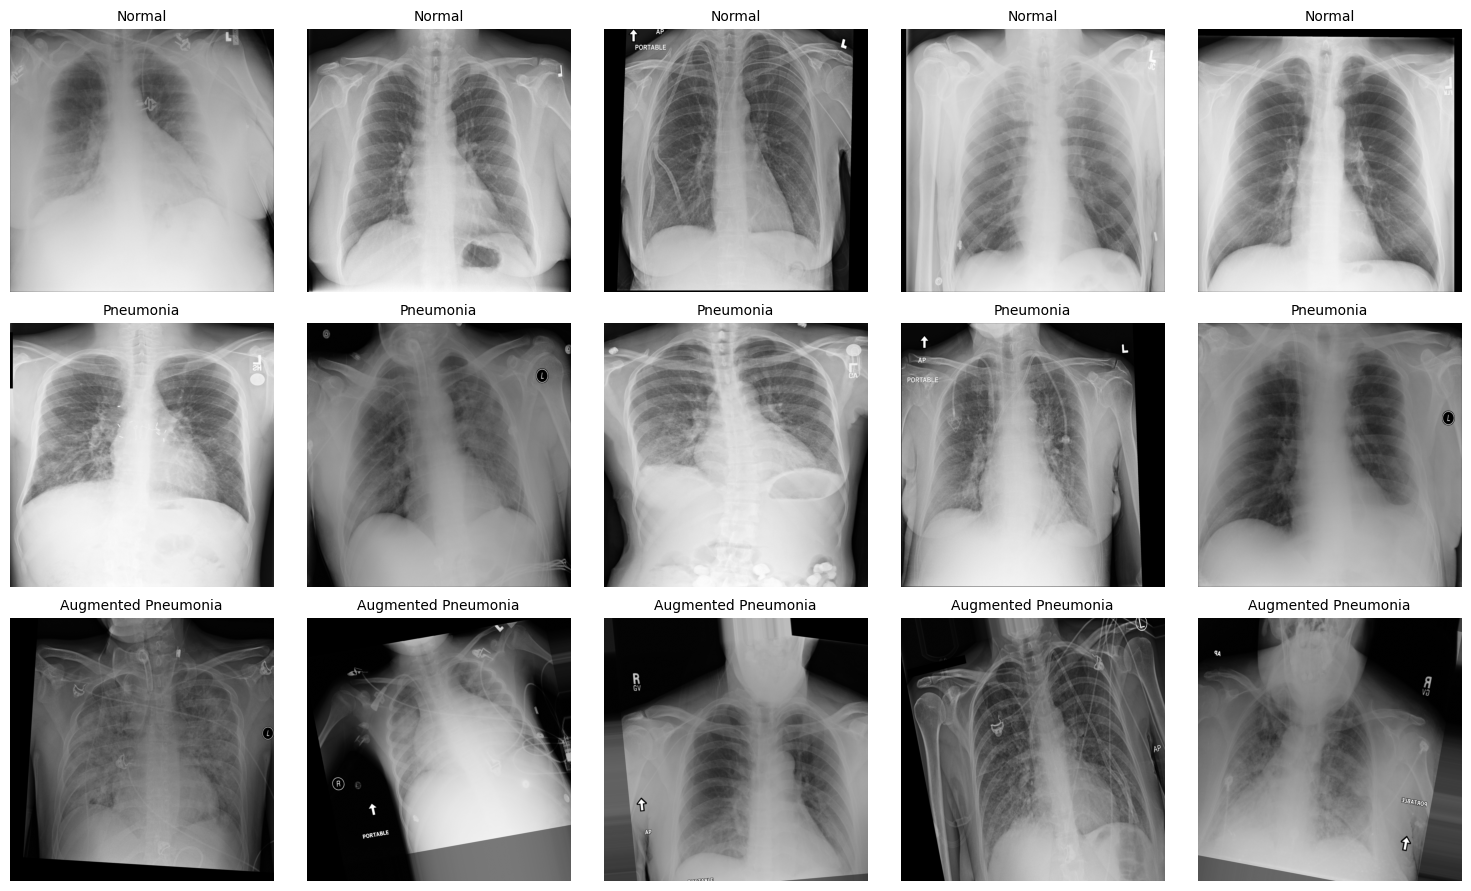

In [ ]:
import cv2
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
sample_norm = normal_train['filepath'].values[:5]
sample_pneu = pneumonia_train['filepath'].values[:5]
sample_aug  = aug_df_sample['filepath'].values[:5]

for i, fpath in enumerate(sample_norm):
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title('Normal', fontsize=10)
    axes[0, i].axis('off')

for i, fpath in enumerate(sample_pneu):
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title('Pneumonia', fontsize=10)
    axes[1, i].axis('off')

for i, fpath in enumerate(sample_aug):
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    axes[2, i].imshow(img, cmap='gray')
    axes[2, i].set_title('Augmented Pneumonia', fontsize=10)
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

#### **Saving the train and test in directory**

In [ ]:
import shutil

output_dir = "/content/drive/MyDrive/NIH_ChestXray/NIH_Processed"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create class subdirectories
for subset in [train_dir, test_dir]:
    os.makedirs(os.path.join(subset, "normal"), exist_ok=True)
    os.makedirs(os.path.join(subset, "pneumonia"), exist_ok=True)

# Copy training images
for _, row in train_df.iterrows():
    label = row['class']
    filename = os.path.basename(row['filepath'])
    dst = os.path.join(train_dir, label, filename)
    shutil.copy(row['filepath'], dst)

# Copy testing images
for _, row in test_df.iterrows():
    label = row['class']
    filename = os.path.basename(row['filepath'])
    dst = os.path.join(test_dir, label, filename)
    shutil.copy(row['filepath'], dst)

print("Images saved to NIH_Processed/train and NIH_Processed/test directories.")

Images saved to NIH_Processed/train and NIH_Processed/test directories.


In [ ]:
import os

def count_images(base_dir):
    counts = {}
    total = 0
    for subset in ["train", "test"]:
        subset_path = os.path.join(base_dir, subset)
        counts[subset] = {}
        for cls in ["normal", "pneumonia"]:
            cls_path = os.path.join(subset_path, cls)
            n = len(os.listdir(cls_path))
            counts[subset][cls] = n
            total += n
    return counts, total

counts, total = count_images(output_dir)

print("Image distribution:")
for subset, subcounts in counts.items():
    print(f" {subset}:")
    for cls, n in subcounts.items():
        print(f"   {cls}: {n}")
print(f"\nTotal images: {total}")


Image distribution:
 train:
   normal: 4069
   pneumonia: 1251
 test:
   normal: 1272
   pneumonia: 512

Total images: 7104


#### **Distribution of the Dataset from saved directory**

In [ ]:
# Cell 1: count images (using path-form) and print simple statements
import os

BASE = "/content/drive/MyDrive/NIH_ChestXray/NIH_Processed"
subset_paths = [os.path.join(BASE, "train"), os.path.join(BASE, "test")]
subset_names = ["train", "test"]
classes = ["normal", "pneumonia"]

# build counts dict: counts['train']['normal'] etc.
counts = {s: {c: 0 for c in classes} for s in subset_names}

for s_name, s_path in zip(subset_names, subset_paths):
    for c in classes:
        p = os.path.join(s_path, c)
        if os.path.isdir(p):
            counts[s_name][c] = len([f for f in os.listdir(p) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        else:
            counts[s_name][c] = 0

# Simple prints (no table)
for s in subset_names:
    tot = counts[s]['normal'] + counts[s]['pneumonia']
    # Avoid division by zero
    if tot > 0:
        pct_norm = counts[s]['normal'] / tot * 100
        pct_pneu = counts[s]['pneumonia'] / tot * 100
    else:
        pct_norm = pct_pneu = 0.0
    print(f"{s.capitalize()}: normal={counts[s]['normal']} ({pct_norm:.2f}%), pneumonia={counts[s]['pneumonia']} ({pct_pneu:.2f}%), total={tot}")


Train: normal=4069 (76.48%), pneumonia=1251 (23.52%), total=5320
Test: normal=1272 (71.30%), pneumonia=512 (28.70%), total=1784


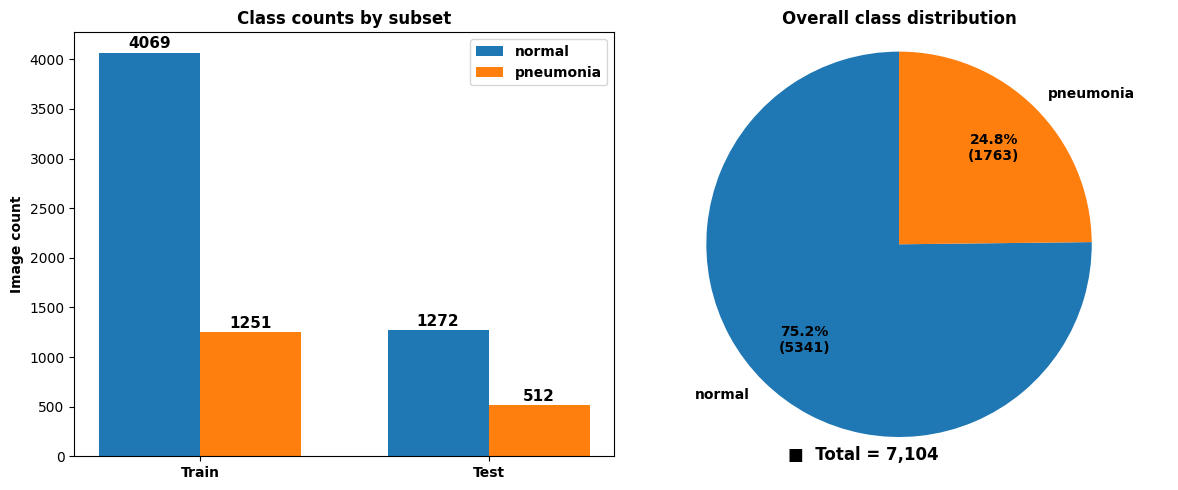

In [ ]:
# Cell: grouped bar + pie subplot + square bullet total under pie
import numpy as np
import matplotlib.pyplot as plt

# Use counts, subset_names, classes from previous cell
vals_norm = [counts[s]['normal'] for s in subset_names]
vals_pneu = [counts[s]['pneumonia'] for s in subset_names]

# totals for pie (overall across train+test)
total_per_class = [sum(counts[s][c] for s in subset_names) for c in classes]
total_all = sum(total_per_class)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Left: grouped bar chart ---
ax = axes[0]
x = np.arange(len(subset_names))
width = 0.35

bars_norm = ax.bar(x - width/2, vals_norm, width, label='normal')
bars_pneu = ax.bar(x + width/2, vals_pneu, width, label='pneumonia')

# Annotate counts (bold) above bars
offset = max(1, int(total_all * 0.002))  # small offset
for bar in list(bars_norm) + list(bars_pneu):
    h = int(bar.get_height())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + offset,
        f"{h}",
        ha='center', va='bottom',
        fontweight='bold',
        fontsize=11
    )

ax.set_xticks(x)
ax.set_xticklabels([s.capitalize() for s in subset_names], fontweight='bold')
ax.set_ylabel("Image count", fontweight='bold')
ax.set_title("Class counts by subset", fontweight='bold')

# Set legend text to bold using prop dict
ax.legend(prop={'weight': 'bold'})
ax.margins(y=0.05)

# --- Right: pie chart with percentage + absolute count in autopct ---
ax2 = axes[1]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({val})"
    return my_autopct

wedges, texts, autotexts = ax2.pie(
    total_per_class,
    labels=classes,
    autopct=make_autopct(total_per_class),
    startangle=90,
    pctdistance=0.7
)

# Style pie text: labels bold, autopct bold
for t in texts:
    t.set_fontweight('bold')
for t in autotexts:
    t.set_fontweight('bold')
    t.set_size(10)

ax2.set_title("Overall class distribution", fontweight='bold')
ax2.axis('equal')  # keep pie circular

# Square bullet + bold Total under the pie chart
# compute center x of the right subplot in figure coordinates
bbox = ax2.get_position()
center_x = bbox.x0 + bbox.width / 2
# place text slightly below the pie (adjust y offset as needed)
fig.text(center_x, bbox.y0 - 0.04, u"\u25A0  Total = {:,}".format(total_all),
         ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

### **Load Dataset Paths**

In [4]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [22]:
# NIH Dataset paths
train_dir = "/content/drive/MyDrive/NIH_ChestXray/NIH_Processed/train"
test_dir = "/content/drive/MyDrive/NIH_ChestXray/NIH_Processed/test"
# Check class imbalance in the NIH dataset
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

#### **Train | Test | Val**

In [23]:
# Check class imbalance
print("NIH Dataset Class Distribution:")
check_class_imbalance(train_dir)
check_class_imbalance(test_dir)

# Define image dimensions and batch size
batch_size = 32
img_size = (224, 224)
seed = 123

# Load datasets with validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='binary', image_size=img_size,
    batch_size=batch_size, validation_split=0.2, subset='training', shuffle=True, seed=seed
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='binary', image_size=img_size,
    batch_size=batch_size, validation_split=0.2, subset='validation', shuffle=True, seed=seed
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='binary', image_size=img_size,
    batch_size=batch_size, shuffle=False
)

# Store class names for use in evaluation
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Calculate class weights to handle imbalance
train_counts = {0: 0, 1: 0}
for _, labels in train_ds:
    for label in labels.numpy():
        train_counts[int(label.item())] += 1

total_samples = sum(train_counts.values())
num_classes = len(train_counts)

# Calculate class weights
class_weights = {
    0: total_samples / (num_classes * train_counts[0]),
    1: total_samples / (num_classes * train_counts[1])
}

print("\nCalculated Class Weights:")
print(class_weights)

NIH Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/NIH_ChestXray/NIH_Processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_ChestXray/NIH_Processed/test
  normal: 1272 images
  pneumonia: 512 images

Found 5320 files belonging to 2 classes.
Using 4256 files for training.
Found 5320 files belonging to 2 classes.
Using 1064 files for validation.
Found 1784 files belonging to 2 classes.
Class names: ['normal', 'pneumonia']

Calculated Class Weights:
{0: 0.6517611026033691, 1: 2.1473259334006056}


In [24]:
# Calculate counts and percentages for NIH train, validation, and test sets

def calculate_nih_dataset_stats(train_ds, val_ds, test_ds):
    """
    Calculate counts and percentages for each class in NIH train, validation, and test sets
    """

    # Get class names from the dataset (binary classification)
    class_names = train_ds.class_names

    # Calculate counts for each dataset
    def count_binary_classes(dataset):
        counts = {0: 0, 1: 0}  # Binary classification
        total = 0
        for images, labels in dataset:
            for label in labels:
                label_val = int(label.numpy())
                counts[label_val] += 1
                total += 1
        return counts, total

    # Calculate statistics for each split
    train_counts, train_total = count_binary_classes(train_ds)
    val_counts, val_total = count_binary_classes(val_ds)
    test_counts, test_total = count_binary_classes(test_ds)

    # Map binary labels to class names
    def map_counts_to_names(counts, class_names):
        return {class_names[i]: counts[i] for i in range(len(class_names))}

    # Create comprehensive statistics dictionary
    nih_stats = {
        'Train': {
            'counts': map_counts_to_names(train_counts, class_names),
            'total': train_total,
            'percentages': {class_names[i]: (train_counts[i]/train_total)*100 for i in range(len(class_names))}
        },
        'Validation': {
            'counts': map_counts_to_names(val_counts, class_names),
            'total': val_total,
            'percentages': {class_names[i]: (val_counts[i]/val_total)*100 for i in range(len(class_names))}
        },
        'Test': {
            'counts': map_counts_to_names(test_counts, class_names),
            'total': test_total,
            'percentages': {class_names[i]: (test_counts[i]/test_total)*100 for i in range(len(class_names))}
        }
    }

    return nih_stats, class_names

# Calculate the statistics for NIH dataset
nih_dataset_stats, nih_class_names = calculate_nih_dataset_stats(train_ds, val_ds, test_ds)

# Display the results
print("="*80)
print("NIH DATASET DISTRIBUTION STATISTICS")
print("="*80)

for split_name, split_data in nih_dataset_stats.items():
    print(f"\n{split_name.upper()} SET:")
    print(f"Total Images: {split_data['total']}")
    print("-" * 40)

    for class_name in nih_class_names:
        count = split_data['counts'].get(class_name, 0)
        percentage = split_data['percentages'].get(class_name, 0)
        print(f"{class_name:15}: {count:4d} images ({percentage:5.1f}%)")

print("\n" + "="*80)
print("NIH OVERALL SUMMARY:")
print("="*80)

# Calculate overall totals
overall_total = sum(split_data['total'] for split_data in nih_dataset_stats.values())
print(f"Total Images Across All Splits: {overall_total}")

# Calculate class distribution across all splits
overall_class_counts = {}
for split_data in nih_dataset_stats.values():
    for class_name, count in split_data['counts'].items():
        overall_class_counts[class_name] = overall_class_counts.get(class_name, 0) + count

print("\nOverall Class Distribution:")
for class_name in nih_class_names:
    count = overall_class_counts.get(class_name, 0)
    percentage = (count/overall_total)*100
    print(f"{class_name:15}: {count:4d} images ({percentage:5.1f}%)")

print(f"\nSplit Distribution:")
for split_name, split_data in nih_dataset_stats.items():
    percentage = (split_data['total']/overall_total)*100
    print(f"{split_name:10}: {split_data['total']:4d} images ({percentage:5.1f}%)")

/tmp/ipython-input-2858836856.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_val = int(label.numpy())


NIH DATASET DISTRIBUTION STATISTICS

TRAIN SET:
Total Images: 4256
----------------------------------------
normal         : 3265 images ( 76.7%)
pneumonia      :  991 images ( 23.3%)

VALIDATION SET:
Total Images: 1064
----------------------------------------
normal         :  804 images ( 75.6%)
pneumonia      :  260 images ( 24.4%)

TEST SET:
Total Images: 1784
----------------------------------------
normal         : 1272 images ( 71.3%)
pneumonia      :  512 images ( 28.7%)

NIH OVERALL SUMMARY:
Total Images Across All Splits: 7104

Overall Class Distribution:
normal         : 5341 images ( 75.2%)
pneumonia      : 1763 images ( 24.8%)

Split Distribution:
Train     : 4256 images ( 59.9%)
Validation: 1064 images ( 15.0%)
Test      : 1784 images ( 25.1%)


#### **Visualize Class Distribution in a Grouped Bar Plot**

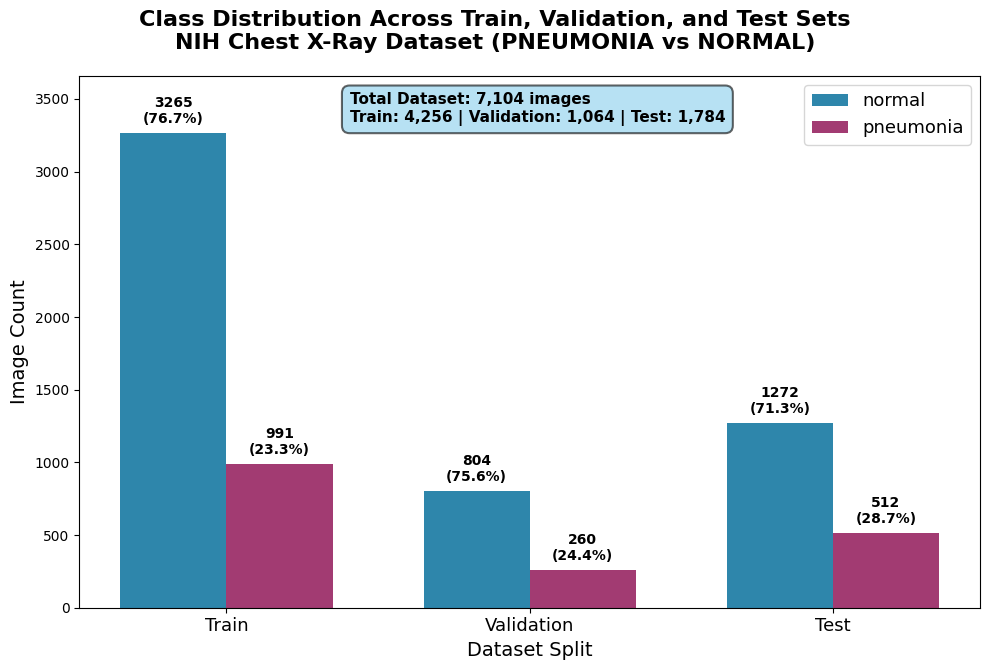


NIH DATASET SPLIT SUMMARY TABLE
Split        normal Count    normal %     pneumonia Count pneumonia %  Total   
-------------------------------------------------------------------------------------
Train        3265            76.7%        991             23.3%        4256    
Validation   804             75.6%        260             24.4%        1064    
Test         1272            71.3%        512             28.7%        1784    


In [25]:
# Create grouped bar plot visualization for NIH dataset

# Prepare data for grouped bar plot using NIH dataset_stats
splits = ['Train', 'Validation', 'Test']

# Create data arrays for each class (using NIH class names)
class1_counts = []  # First class
class2_counts = []  # Second class
class1_pcts = []
class2_pcts = []

for split in splits:
    class1_count = nih_dataset_stats[split]['counts'].get(nih_class_names[0], 0)
    class2_count = nih_dataset_stats[split]['counts'].get(nih_class_names[1], 0)
    total = nih_dataset_stats[split]['total']

    class1_counts.append(class1_count)
    class2_counts.append(class2_count)
    class1_pcts.append(f"{(class1_count/total)*100:.1f}")
    class2_pcts.append(f"{(class2_count/total)*100:.1f}")

# Convert to numpy arrays for easier manipulation
class1_counts = np.array(class1_counts)
class2_counts = np.array(class2_counts)

# Set up the plot
bar_width = 0.35
set_names = splits
indices = np.arange(len(set_names))

fig, ax = plt.subplots(figsize=(10, 7))

# Plot bars for each class, side by side within each data split
# Using pastel colors: sky blue for first class, pastel orange for second class
bars1 = ax.bar(indices - bar_width/2, class1_counts, bar_width,
               label=nih_class_names[0], color='#2E86AB')
bars2 = ax.bar(indices + bar_width/2, class2_counts, bar_width,
               label=nih_class_names[1], color='#A23B72')

# Annotate all bars with counts and %
for idx, (cnt, pct) in enumerate(zip(class1_counts, class1_pcts)):
    ax.annotate(f'{cnt}\n({pct}%)', xy=(indices[idx] - bar_width/2, cnt),
                xytext=(0,5), textcoords="offset points", ha='center', va='bottom',
                fontsize=10, fontweight='bold')
for idx, (cnt, pct) in enumerate(zip(class2_counts, class2_pcts)):
    ax.annotate(f'{cnt}\n({pct}%)', xy=(indices[idx] + bar_width/2, cnt),
                xytext=(0,5), textcoords="offset points", ha='center', va='bottom',
                fontsize=10, fontweight='bold')

# Add summary statistics as text box
total_images = overall_total
textstr = f'Total Dataset: {total_images:,} images\n'
textstr += f'Train: {nih_dataset_stats["Train"]["total"]:,} | '
textstr += f'Validation: {nih_dataset_stats["Validation"]["total"]:,} | '
textstr += f'Test: {nih_dataset_stats["Test"]["total"]:,}'

props = dict(boxstyle='round,pad=0.5', facecolor='skyblue', edgecolor='black', linewidth=1.5, alpha=0.6)
ax.text(0.30, 0.97, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top',horizontalalignment='left', bbox=props, fontweight='bold')

# Cosmetics
ax.set_xlabel('Dataset Split', fontsize=14)
ax.set_ylabel('Image Count', fontsize=14)
ax.set_xticks(indices)
ax.set_xticklabels(set_names, fontsize=13)
ax.legend(fontsize=13)
plt.ylim(0, max(class1_counts.max(), class2_counts.max())*1.12)

# Modern, descriptive title
fig.suptitle(
    "Class Distribution Across Train, Validation, and Test Sets\nNIH Chest X-Ray Dataset (PNEUMONIA vs NORMAL)",
    fontsize=16,
    ha='center',
    y=0.95, fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Optional: Create a summary table for NIH dataset
print("\n" + "="*60)
print("NIH DATASET SPLIT SUMMARY TABLE")
print("="*60)

# Create a formatted table
nih_summary_data = []
for split in ['Train', 'Validation', 'Test']:
    class1_count = nih_dataset_stats[split]['counts'].get(nih_class_names[0], 0)
    class2_count = nih_dataset_stats[split]['counts'].get(nih_class_names[1], 0)
    total = nih_dataset_stats[split]['total']
    class1_pct = (class1_count / total) * 100
    class2_pct = (class2_count / total) * 100

    nih_summary_data.append([
        split, class1_count, f"{class1_pct:.1f}%",
        class2_count, f"{class2_pct:.1f}%", total
    ])

# Print formatted table
headers = ['Split', f'{nih_class_names[0]} Count', f'{nih_class_names[0]} %',
           f'{nih_class_names[1]} Count', f'{nih_class_names[1]} %', 'Total']
print(f"{'Split':<12} {f'{nih_class_names[0]} Count':<15} {f'{nih_class_names[0]} %':<12} {f'{nih_class_names[1]} Count':<15} {f'{nih_class_names[1]} %':<12} {'Total':<8}")
print("-" * 85)
for row in nih_summary_data:
    print(f"{row[0]:<12} {row[1]:<15} {row[2]:<12} {row[3]:<15} {row[4]:<12} {row[5]:<8}")

#### **Geometric Augmentation(On-the-fly) Samples**

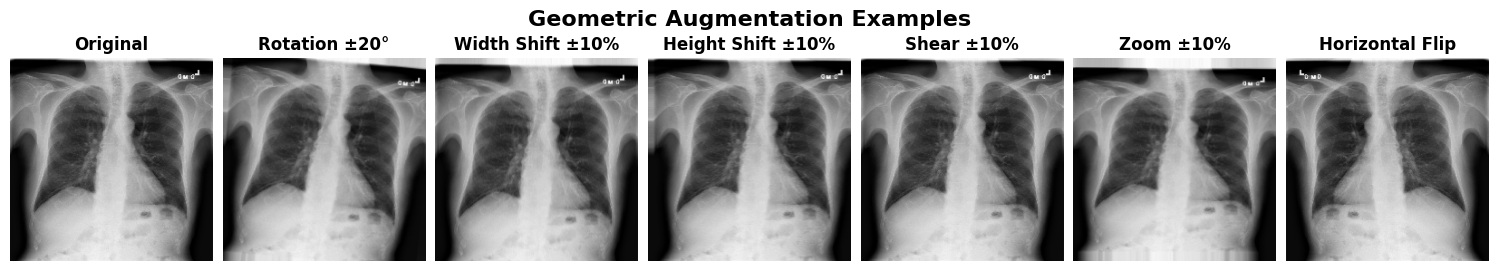

Augmentation Parameters Used in Your Code:
Rotation range: ±20 degrees
Width shift range: ±10%
Height shift range: ±10%
Shear range: ±10%
Zoom range: ±10%
Horizontal flip: Enabled
Fill mode: Nearest


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load a sample image
sample_image_path = "/content/drive/MyDrive/NIH_processed/val/normal/00000143_004.png"
img = load_img(sample_image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Create individual augmentation generators for each transformation
augmentations = [
    ("Original", ImageDataGenerator()),
    ("Rotation ±20°", ImageDataGenerator(rotation_range=20, fill_mode="nearest")),
    ("Width Shift ±10%", ImageDataGenerator(width_shift_range=0.1, fill_mode="nearest")),
    ("Height Shift ±10%", ImageDataGenerator(height_shift_range=0.1, fill_mode="nearest")),
    ("Shear ±10%", ImageDataGenerator(shear_range=0.1, fill_mode="nearest")),
    ("Zoom ±10%", ImageDataGenerator(zoom_range=0.1, fill_mode="nearest")),
    ("Horizontal Flip", ImageDataGenerator(horizontal_flip=True, fill_mode="nearest"))
]

# Generate augmented images
augmented_images = []
titles = []

for title, generator in augmentations:
    if title == "Original":
        augmented = img_array[0]
    else:
        # For reproducible results
        np.random.seed(42)
        augmented = generator.random_transform(img_array[0])

    augmented_images.append(augmented)
    titles.append(title)

# Plot the images in a single row, nicely packed
n = len(augmented_images)
fig, axes = plt.subplots(1, n, figsize=(n * 2.2, 3))  # one row, n cols

for i, (ax, im, title) in enumerate(zip(axes, augmented_images, titles)):
    ax.imshow(im.astype('uint8'))
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.axis('off')

plt.suptitle('Geometric Augmentation Examples', fontsize=16, fontweight='bold')

# Reduce horizontal space between subplots so images sit closer together
plt.subplots_adjust(wspace=0.05, top=0.85, left=0.02, right=0.98)

plt.savefig('/content/drive/MyDrive/NIH_processed/augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# Print augmentation parameters
print("Augmentation Parameters Used in Your Code:")
print(f"Rotation range: ±20 degrees")
print(f"Width shift range: ±10%")
print(f"Height shift range: ±10%")
print(f"Shear range: ±10%")
print(f"Zoom range: ±10%")
print(f"Horizontal flip: Enabled")
print(f"Fill mode: Nearest")